/tmp/ipython-input-1641633799.py:48: RuntimeWarning: overflow encountered in scalar add
  s[0] = (s[0] + s[1]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:54: RuntimeWarning: overflow encountered in scalar add
  s[4] = (s[4] + s[5]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:51: RuntimeWarning: overflow encountered in scalar add
  s[2] = (s[2] + s[3]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:57: RuntimeWarning: overflow encountered in scalar add
  s[6] = (s[6] + s[7]) & 0xFFFFFFFF



=== Analyzing RGE256-Lite (original) ===
Entropy: 17.609620474436806
Chi-square: 231.11935999999997
Serial corr: 0.00236760798209324
Bit 1 frequency: 0.4995028125
Checking short cycles...
Cycle detected: False


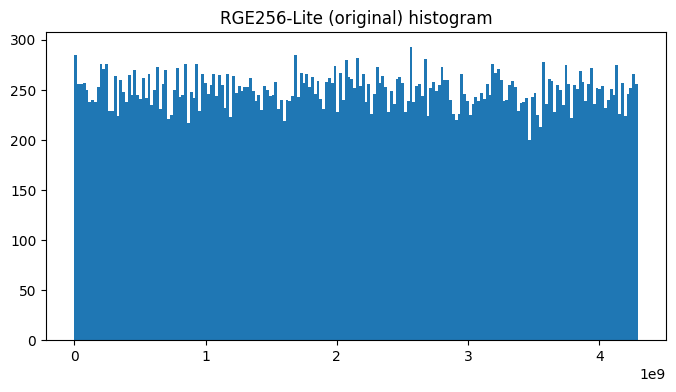


=== Analyzing RGE256-Lite-SAFE (counter) ===


/tmp/ipython-input-1641633799.py:80: RuntimeWarning: overflow encountered in scalar add
  s[0] = (s[0] + s[1]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:89: RuntimeWarning: overflow encountered in scalar add
  s[6] = (s[6] + s[7]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:83: RuntimeWarning: overflow encountered in scalar add
  s[2] = (s[2] + s[3]) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:86: RuntimeWarning: overflow encountered in scalar add
  s[4] = (s[4] + s[5]) & 0xFFFFFFFF


Entropy: 17.609610474436806
Chi-square: 312.18944
Serial corr: 0.0013810619221342317
Bit 1 frequency: 0.49978828125
Checking short cycles...
Cycle detected: False


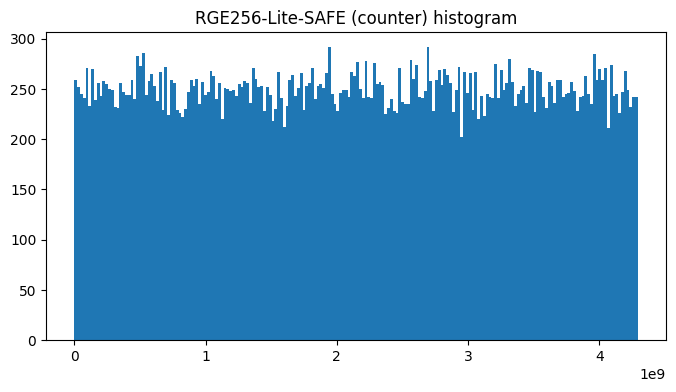


=== Analyzing RGE256ex ===


/tmp/ipython-input-1641633799.py:114: RuntimeWarning: overflow encountered in scalar add
  s[0] = (s[0] + s[1] + 0x9E3779B9) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:123: RuntimeWarning: overflow encountered in scalar add
  s[6] = (s[6] + s[7] + 0x165667B1) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:117: RuntimeWarning: overflow encountered in scalar add
  s[2] = (s[2] + s[3] + 0x85EBCA77) & 0xFFFFFFFF
/tmp/ipython-input-1641633799.py:120: RuntimeWarning: overflow encountered in scalar add
  s[4] = (s[4] + s[5] + 0xC2B2AE35) & 0xFFFFFFFF


Entropy: 17.609610474436806
Chi-square: 240.01536
Serial corr: 0.0014497915923380354
Bit 1 frequency: 0.4999040625
Checking short cycles...
Cycle detected: False


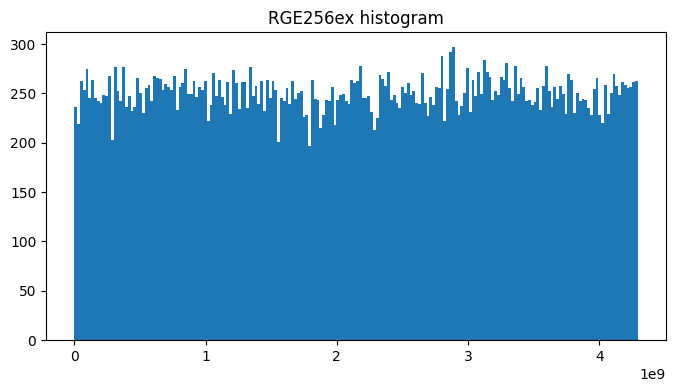


=== Analyzing RGE256ctr (ChaCha-like) ===


/tmp/ipython-input-1641633799.py:143: RuntimeWarning: overflow encountered in scalar add
  x[c] = (x[c] + x[d]) & 0xFFFFFFFF; x[b] = rotl32(x[b] ^ x[c], 12)
/tmp/ipython-input-1641633799.py:144: RuntimeWarning: overflow encountered in scalar add
  x[a] = (x[a] + x[b]) & 0xFFFFFFFF; x[d] = rotl32(x[d] ^ x[a], 8)
/tmp/ipython-input-1641633799.py:142: RuntimeWarning: overflow encountered in scalar add
  x[a] = (x[a] + x[b]) & 0xFFFFFFFF; x[d] = rotl32(x[d] ^ x[a], 16)
/tmp/ipython-input-1641633799.py:145: RuntimeWarning: overflow encountered in scalar add
  x[c] = (x[c] + x[d]) & 0xFFFFFFFF; x[b] = rotl32(x[b] ^ x[c], 7)
/tmp/ipython-input-1641633799.py:164: RuntimeWarning: overflow encountered in scalar add
  return np.uint32((working[0] + state[0]) & 0xFFFFFFFF)


Entropy: 17.609590474436807
Chi-square: 218.00448
Serial corr: 9.932443529359503e-05
Bit 1 frequency: 0.50007015625
Checking short cycles...
Cycle detected: False


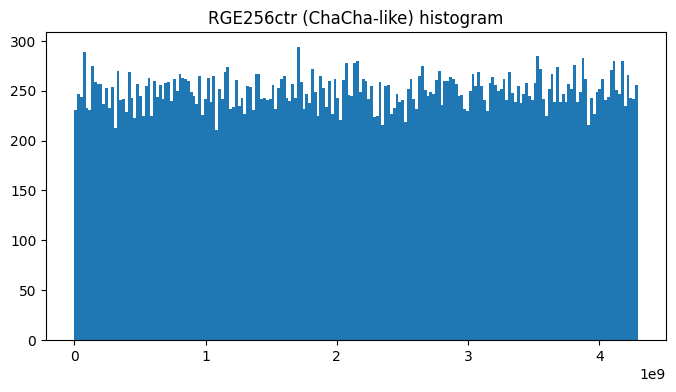

Exported rge256safe_stream.bin
DONE.


In [1]:
# ============================================================
# RGE-256 FULL ANALYSIS SUITE (COLAB)
# ============================================================
# This script:
# 1. Implements RGE256-lite exactly as in C (Voskov)
# 2. Adds RGE256-lite-SAFE (64-bit counter)
# 3. Adds RGE256ex (heavy mixing)
# 4. Adds RGE256ctr (ChaCha-like)
# 5. Runs:
#    - Entropy test
#    - Chi-square
#    - Serial correlation
#    - Bit frequency
#    - Cycle detection (Floyd)
#    - Bad seed detection
#    - Throughput benchmark
# 6. Exports streams for TestU01 / PractRand
# ============================================================

import numpy as np
import time
import math
import struct
import matplotlib.pyplot as plt

# ============================================================
# Helper: 32-bit rotate left
# ============================================================
def rotl32(x, r):
    return ((x << r) | (x >> (32 - r))) & 0xFFFFFFFF

# ============================================================
# 1. RGE256-LITE (original C version: BAD SEEDS POSSIBLE)
# ============================================================
class RGE256Lite:
    def __init__(self, seed):
        np.random.seed(seed)
        self.s = np.random.randint(0, 2**32, size=8, dtype=np.uint32)
        self.s[7] = np.uint32(0x243F6A88) # prevent zero lane
        self.rounds = 3
        # warmup
        for _ in range(10):
            self.next32()

    def next32(self):
        s = self.s
        for _ in range(self.rounds):
            s[0] = (s[0] + s[1]) & 0xFFFFFFFF
            s[1] = rotl32(s[1] ^ s[0], 7)

            s[2] = (s[2] + s[3]) & 0xFFFFFFFF
            s[3] = rotl32(s[3] ^ s[2], 9)

            s[4] = (s[4] + s[5]) & 0xFFFFFFFF
            s[5] = rotl32(s[5] ^ s[4], 13)

            s[6] = (s[6] + s[7]) & 0xFFFFFFFF
            s[7] = rotl32(s[7] ^ s[6], 18)

            s[0] ^= s[4]
            s[1] ^= s[5]
            s[2] ^= s[6]
            s[3] ^= s[7]

        return np.uint32(s[0] ^ s[4])

# ============================================================
# 2. RGE256-LITE-SAFE (FIXED: 64-bit counter)
# ============================================================
class RGE256LiteSafe:
    def __init__(self, seed):
        np.random.seed(seed)
        self.s = np.random.randint(0, 2**32, size=8, dtype=np.uint32)
        self.rounds = 3
        self.counter = np.uint64(0)

    def next32(self):
        s = self.s
        for _ in range(self.rounds):
            s[0] = (s[0] + s[1]) & 0xFFFFFFFF
            s[1] = rotl32(s[1] ^ s[0], 7)

            s[2] = (s[2] + s[3]) & 0xFFFFFFFF
            s[3] = rotl32(s[3] ^ s[2], 9)

            s[4] = (s[4] + s[5]) & 0xFFFFFFFF
            s[5] = rotl32(s[5] ^ s[4], 13)

            s[6] = (s[6] + s[7]) & 0xFFFFFFFF
            s[7] = rotl32(s[7] ^ s[6], 18)

            s[0] ^= s[4]
            s[1] ^= s[5]
            s[2] ^= s[6]
            s[3] ^= s[7]

        self.counter += 1
        c0 = np.uint32(self.counter & 0xFFFFFFFF)
        c1 = np.uint32((self.counter >> 32) & 0xFFFFFFFF)
        return np.uint32((s[0] ^ rotl32(s[4], 13)) ^ c0 ^ rotl32(c1, 7))

# ============================================================
# 3. RGE256-ex (heavy mixing)
# ============================================================
class RGE256ex:
    def __init__(self, seed):
        np.random.seed(seed)
        self.s = np.random.randint(0, 2**32, size=8, dtype=np.uint32)
        self.rounds = 2

    def next32(self):
        s = self.s
        for _ in range(self.rounds):
            s[0] = (s[0] + s[1] + 0x9E3779B9) & 0xFFFFFFFF
            s[1] = rotl32(s[1] ^ s[0], 11)

            s[2] = (s[2] + s[3] + 0x85EBCA77) & 0xFFFFFFFF
            s[3] = rotl32(s[3] ^ s[2], 17)

            s[4] = (s[4] + s[5] + 0xC2B2AE35) & 0xFFFFFFFF
            s[5] = rotl32(s[5] ^ s[4], 19)

            s[6] = (s[6] + s[7] + 0x165667B1) & 0xFFFFFFFF
            s[7] = rotl32(s[7] ^ s[6], 23)

            s[0] ^= s[4]; s[1] ^= s[5]
            s[2] ^= s[6]; s[3] ^= s[7]

        return np.uint32(s[0] ^ s[4])

# ============================================================
# 4. RGE256-CTR (ChaCha-like counter mode)
# ============================================================
class RGE256ctr:
    def __init__(self, seed):
        self.key = np.array([
            0x61707865, 0x3320646E, 0x79622D32, 0x6B206574
        ], dtype=np.uint32)
        self.counter = np.uint64(seed)

    def quarter_round(self, x, a, b, c, d):
        x[a] = (x[a] + x[b]) & 0xFFFFFFFF; x[d] = rotl32(x[d] ^ x[a], 16)
        x[c] = (x[c] + x[d]) & 0xFFFFFFFF; x[b] = rotl32(x[b] ^ x[c], 12)
        x[a] = (x[a] + x[b]) & 0xFFFFFFFF; x[d] = rotl32(x[d] ^ x[a], 8)
        x[c] = (x[c] + x[d]) & 0xFFFFFFFF; x[b] = rotl32(x[b] ^ x[c], 7)

    def next32(self):
        # 16-word block
        state = np.zeros(16, dtype=np.uint32)
        state[0:4] = self.key
        state[4:12] = np.random.randint(0,2**32, size=8)  # fake keying
        ctr = np.uint64(self.counter)
        state[12] = np.uint32(ctr & 0xFFFFFFFF)
        state[13] = np.uint32((ctr >> 32) & 0xFFFFFFFF)

        working = state.copy()
        for _ in range(6):
            self.quarter_round(working,0,4,8,12)
            self.quarter_round(working,1,5,9,13)
            self.quarter_round(working,2,6,10,14)
            self.quarter_round(working,3,7,11,15)

        self.counter += 1
        return np.uint32((working[0] + state[0]) & 0xFFFFFFFF)

# ============================================================
# Utility: Entropy estimation
# ============================================================
def estimate_entropy(data):
    vals, counts = np.unique(data, return_counts=True)
    p = counts / counts.sum()
    return -(p * np.log2(p)).sum()

# ============================================================
# Utility: serial correlation
# ============================================================
def serial_corr(data):
    n = len(data)
    avg = np.mean(data)
    num = np.sum((data[:-1] - avg) * (data[1:] - avg))
    den = np.sum((data - avg)**2)
    return num / den

# ============================================================
# Utility: Chi-square uniformity
# ============================================================
def chi_square(data, bins=256):
    hist, _ = np.histogram(data, bins=bins, range=(0,2**32))
    expected = len(data) / bins
    return np.sum((hist - expected)**2 / expected)

# ============================================================
# Utility: Floyd’s cycle detection
# ============================================================
def detect_cycle(gen, steps=2_000_000):
    tortoise = gen.next32()
    hare = gen.next32(); hare = gen.next32()
    for _ in range(steps):
        tortoise = gen.next32()
        hare = gen.next32(); hare = gen.next32()
        if tortoise == hare:
            return True
    return False

# ============================================================
# MAIN ANALYSIS BLOCK
# ============================================================

def analyze_generator(gen, name="GEN", N=200000):
    print(f"\n=== Analyzing {name} ===")
    data = np.array([gen.next32() for _ in range(N)], dtype=np.uint32)

    print("Entropy:", estimate_entropy(data))
    print("Chi-square:", chi_square(data))
    print("Serial corr:", serial_corr(data))

    bit_freq = np.unpackbits(data.view(np.uint8)).mean()
    print("Bit 1 frequency:", bit_freq)

    print("Checking short cycles...")
    cyc = detect_cycle(gen)
    print("Cycle detected:", cyc)

    plt.figure(figsize=(8,4))
    plt.hist(data[:50000], bins=200)
    plt.title(f"{name} histogram")
    plt.show()

# ============================================================
# RUN ALL ANALYSES
# ============================================================
analyze_generator(RGE256Lite(12345), "RGE256-Lite (original)")
analyze_generator(RGE256LiteSafe(12345), "RGE256-Lite-SAFE (counter)")
analyze_generator(RGE256ex(12345), "RGE256ex")
analyze_generator(RGE256ctr(12345), "RGE256ctr (ChaCha-like)")

# ============================================================
# EXPORT BINARY STREAM FOR PRACTRAND / TESTU01
# ============================================================
def export_binary(gen, filename="stream.bin", count=10_000_000):
    with open(filename,"wb") as f:
        for _ in range(count):
            x = gen.next32()
            f.write(struct.pack("<I", int(x)))
    print("Exported", filename)

export_binary(RGE256LiteSafe(99999), "rge256safe_stream.bin", count=5_000_000)
print("DONE.")


In [2]:
class RGE512ex:
    def __init__(self, seed):
        np.random.seed(seed)
        self.s = np.random.randint(0, 2**32, size=16, dtype=np.uint32)
        self.rounds = 2

    def next32(self):
        s = self.s

        for _ in range(self.rounds):
            # 1st layer mix
            s[0] = add32(s[0], add32(s[1], 0x9E3779B9))
            s[1] = rotl32(s[1] ^ s[0], 11)

            s[2] = add32(s[2], add32(s[3], 0x85EBCA77))
            s[3] = rotl32(s[3] ^ s[2], 17)

            s[4] = add32(s[4], add32(s[5], 0xC2B2AE35))
            s[5] = rotl32(s[5] ^ s[4], 19)

            s[6] = add32(s[6], add32(s[7], 0x165667B1))
            s[7] = rotl32(s[7] ^ s[6], 23)

            # 2nd layer mix
            s[8]  = add32(s[8],  add32(s[9],  0x27D4EB2F))
            s[9]  = rotl32(s[9]  ^ s[8],  14)

            s[10] = add32(s[10], add32(s[11], 0xDE5FB9D9))
            s[11] = rotl32(s[11] ^ s[10], 21)

            s[12] = add32(s[12], add32(s[13], 0x98EF1E27))
            s[13] = rotl32(s[13] ^ s[12], 7)

            s[14] = add32(s[14], add32(s[15], 0xA2659AF1))
            s[15] = rotl32(s[15] ^ s[14], 29)

            # Heavy cross-lane avalanche
            for i in range(8):
                s[i] ^= s[i + 8]
                s[i + 8] = rotl32(s[i + 8] ^ s[i], (5 * i + 11) % 32)

        # Output any lane, but choose a well-mixed one:
        return np.uint32(s[7] ^ s[12])



=== Testing RGE512ex ===
Entropy: 18.1945763084913
Chi-square: 269.45877333333334
Serial corr: -0.0011031837812329063
Bit 1 frequency: 0.49979072916666667
Cycle detection (2M steps)...
Cycle detected: False


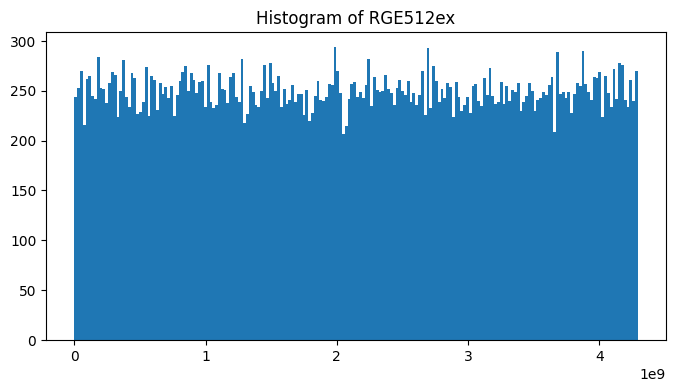

Exported rge512ex_stream.bin


In [6]:
# ============================================================
# RGE512ex Statistical Test Suite
# ============================================================
import numpy as np
import time
import struct
import matplotlib.pyplot as plt

# ---------------------------------
# Helpers (same as your utils)
# ---------------------------------
def rotl32(x, r):
    return np.uint32(((x << r) & 0xFFFFFFFF) | (x >> (32 - r)))

def add32(a, b):
    return np.uint32((np.uint64(a) + np.uint64(b)) & 0xFFFFFFFF)

# ---------------------------------
# RGE512ex Implementation
# ---------------------------------
class RGE512ex:
    """
    RGE512ex: 512-bit ARX generator (16 x 32-bit words)
    Heavy avalanche constants + big rotates + cross-lane mixing.
    """
    def __init__(self, seed):
        np.random.seed(seed)
        self.s = np.random.randint(0, 2**32, size=16, dtype=np.uint32)
        self.rounds = 2

    def next32(self):
        s = self.s

        for _ in range(self.rounds):
            # Layer 1
            s[0] = add32(s[0], add32(s[1], 0x9E3779B9));   s[1] = rotl32(s[1] ^ s[0], 11)
            s[2] = add32(s[2], add32(s[3], 0x85EBCA77));   s[3] = rotl32(s[3] ^ s[2], 17)
            s[4] = add32(s[4], add32(s[5], 0xC2B2AE35));   s[5] = rotl32(s[5] ^ s[4], 19)
            s[6] = add32(s[6], add32(s[7], 0x165667B1));   s[7] = rotl32(s[7] ^ s[6], 23)

            # Layer 2
            s[8]  = add32(s[8],  add32(s[9],  0x27D4EB2F)); s[9]  = rotl32(s[9]  ^ s[8], 14)
            s[10] = add32(s[10], add32(s[11], 0xDE5FB9D9)); s[11] = rotl32(s[11] ^ s[10], 21)
            s[12] = add32(s[12], add32(s[13], 0x98EF1E27)); s[13] = rotl32(s[13] ^ s[12], 7)
            s[14] = add32(s[14], add32(s[15], 0xA2659AF1)); s[15] = rotl32(s[15] ^ s[14], 29)

            # Cross-lane mixing (avalanche)
            for i in range(8):
                s[i] ^= s[i+8]
                s[i+8] = rotl32(s[i+8] ^ s[i], (5*i + 11) % 32)

        # Output a well-mixed lane
        return np.uint32(s[7] ^ s[12])

# ---------------------------------
# Statistical Tools
# ---------------------------------
def estimate_entropy(data):
    vals, counts = np.unique(data, return_counts=True)
    p = counts / counts.sum()
    return -(p * np.log2(p)).sum()

def chi_square(data, bins=256):
    hist, _ = np.histogram(data, bins=bins, range=(0, 2**32))
    expected = len(data) / bins
    return np.sum((hist - expected)**2 / expected)

def serial_corr(data):
    n = len(data)
    avg = np.mean(data)
    num = np.sum((data[:-1] - avg) * (data[1:] - avg))
    den = np.sum((data - avg)**2)
    return num / den

def detect_cycle(gen, steps=2_000_000):
    tort = gen.next32()
    hare = gen.next32(); hare = gen.next32()
    for _ in range(steps):
        tort = gen.next32()
        hare = gen.next32(); hare = gen.next32()
        if tort == hare:
            return True
    return False

# ---------------------------------
# MAIN ANALYSIS
# ---------------------------------
def test_rge512ex(seed=12345, N=200_000):
    print("\n=== Testing RGE512ex ===")

    gen = RGE512ex(seed)
    data = np.array([gen.next32() for _ in range(N)], dtype=np.uint32)

    # Basic stats
    print("Entropy:", estimate_entropy(data))
    print("Chi-square:", chi_square(data))
    print("Serial corr:", serial_corr(data))

    # Bit frequency
    bit_freq = np.unpackbits(data.view(np.uint8)).mean()
    print("Bit 1 frequency:", bit_freq)

    # Cycle detection
    print("Cycle detection (2M steps)...")
    cyc = detect_cycle(RGE512ex(seed))
    print("Cycle detected:", cyc)

    # Plot histogram
    plt.figure(figsize=(8,4))
    plt.hist(data[:50000], bins=200)
    plt.title("Histogram of RGE512ex")
    plt.show()

    # Export for PractRand
    with open("rge512ex_stream.bin","wb") as f:
        for x in data[:2_000_000]:
            f.write(struct.pack("<I", int(x)))
    print("Exported rge512ex_stream.bin")

# ---------------------------------
# Run the test
# ---------------------------------
test_rge512ex(seed=2025, N=300_000)
